#### Student Name:
#### Student ID:

# Assignment 6

### PCA with Linear Autoencoder

Instructions: 

* This notebook is an interactive assignment; please read and follow the instructions in each cell. 

* Cells that require your input (in the form of code or written response) will have 'Question #' above.

* After completing the assignment, please submit this notebook as a PDF.


You may need to run the following commands to set up your environment:

`pip install tensorflow`

`pip install keras`

`pip install --upgrade protobuf`

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
#!{__import__('sys').executable} -m pip install --upgrade --quiet --user tensorflow tensorflow-gpu keras numpy matplotlib scipy librosa music21

import numpy as np
from scipy.io import wavfile
from numpy.linalg import svd
from scipy.stats.mstats import gmean
import scipy
import os
import sys
import glob
import pickle
from music21 import converter, instrument, note, chord, stream
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation, Lambda
from keras.layers import BatchNormalization as BatchNorm
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()
tf.disable_v2_behavior()

2022-07-25 03:08:52.080922: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Instructions for updating:
non-resource variables are not supported in the long term


# PCA with a Linear Autoencoder

In this problem, we will practice using basic neural network procedures by running an autoencoder network.
This network is implemented in TensorFlow (essentially Keras with an expanded toolset); the functions we call are nearly identical to those you will see in Keras. 

Let's create a sin+noise signal to use as input to our network:

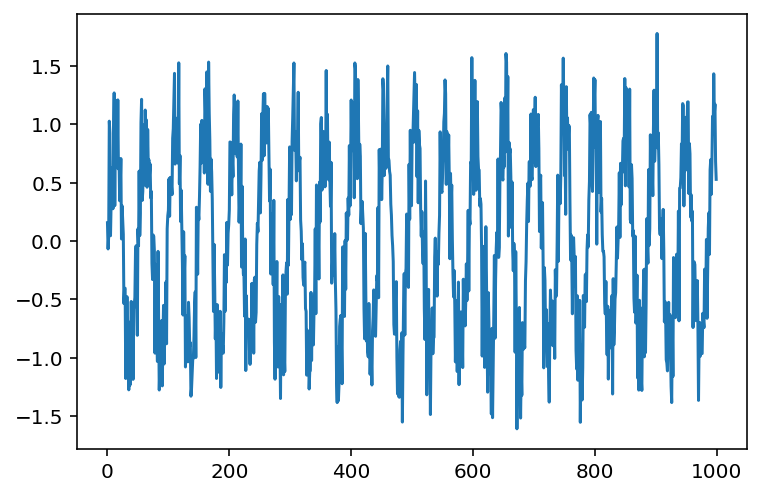

In [3]:
f0 = 203
fs = 10000
T = 3
Ns = fs*T

def buffer(input_data, sample_rate, window_size, hop_size):
    output = np.array([input_data[i:i+window_size] for i in range(0, len(input_data)-window_size, hop_size)])
    return output.T

s = np.sin(2*np.pi*f0*np.arange(Ns)/fs)

n = np.random.randn(Ns)

x = s + 0.3*n 

plt.plot(x[:1000])
wavfile.write('out2.wav', fs, x)
xmat = buffer(x,fs,400,200)

Here we create an AE with 2 hidden layers. 

This neural network is implemented in TensorFlow. 

Please review the code cells below, and answer the questions that follow. 

In [4]:
n_inputs = np.shape(xmat)[0]
n_hidden = 2 

learning_rate = 0.01 

X = tf.compat.v1.placeholder(tf.float32, shape=[None, n_inputs])
W = tf.Variable(tf.truncated_normal(stddev=.1, shape =[n_inputs,n_hidden]))

hidden = tf.matmul(X,W)
outputs = tf.matmul(hidden,tf.transpose(W))

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)

init = tf.global_variables_initializer()

2022-07-25 03:08:59.416544: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-25 03:09:00.701922: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 341 MB memory:  -> device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:b2:00.0, compute capability: 7.5
2022-07-25 03:09:00.714120: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled


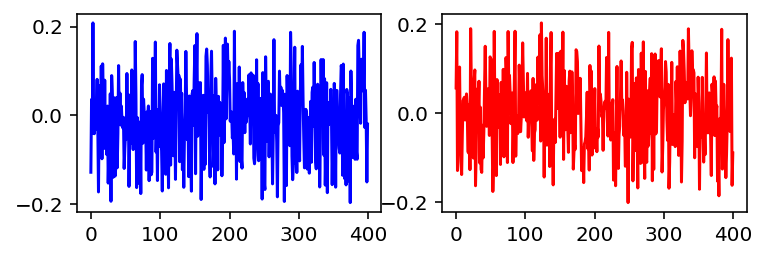

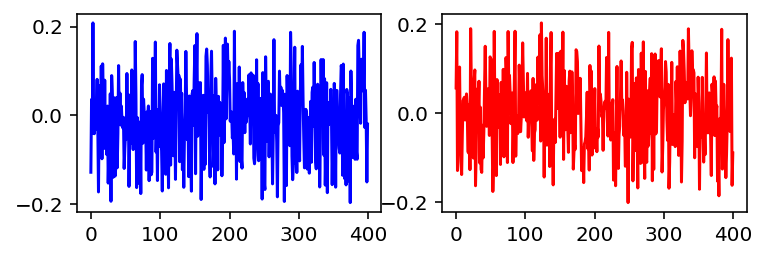

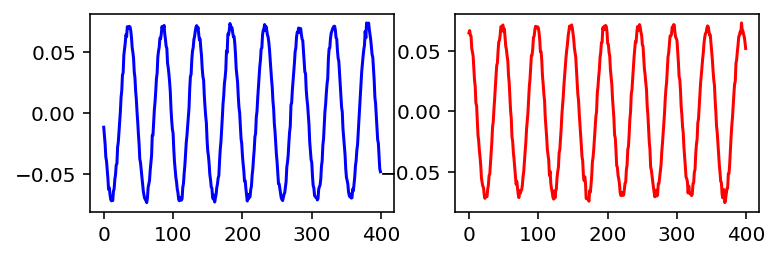

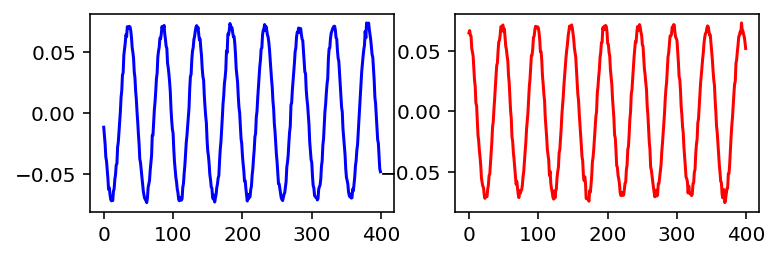

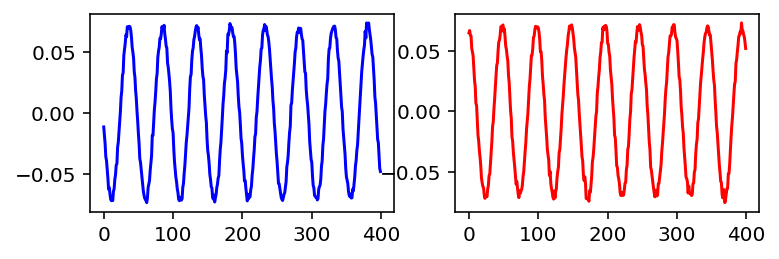

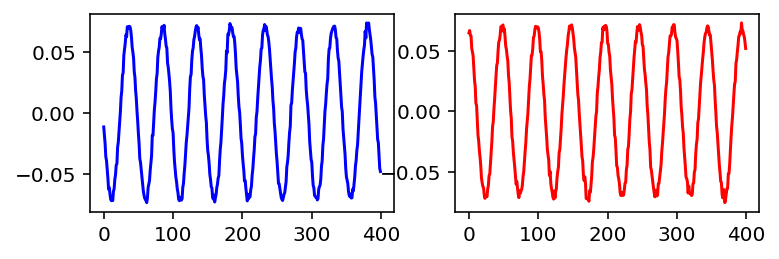

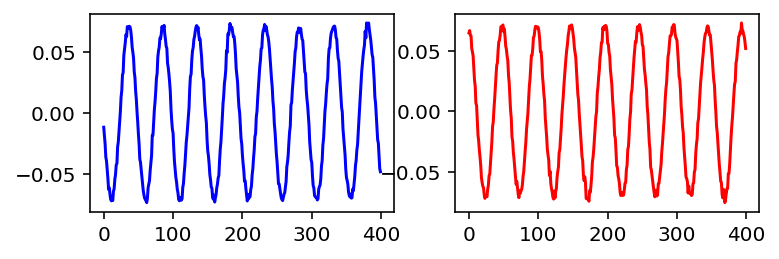

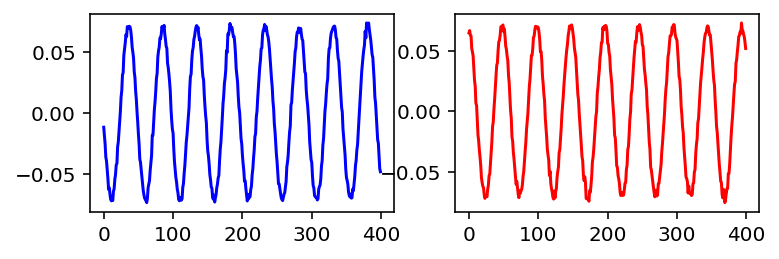

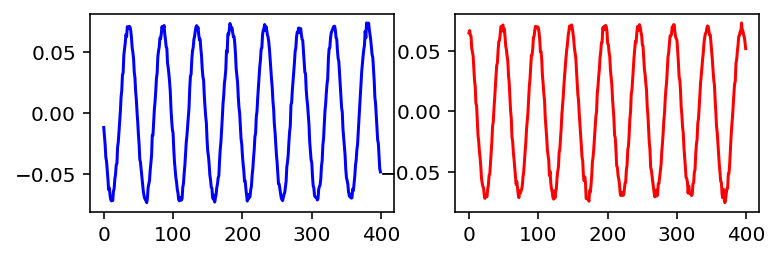

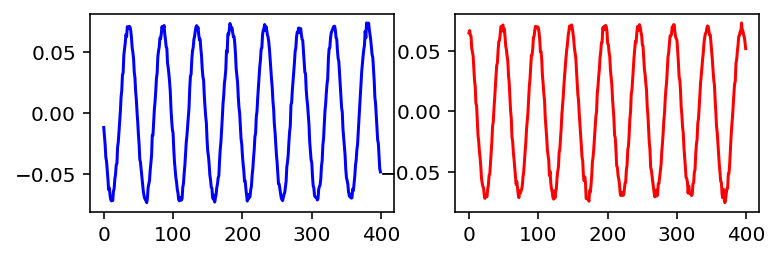

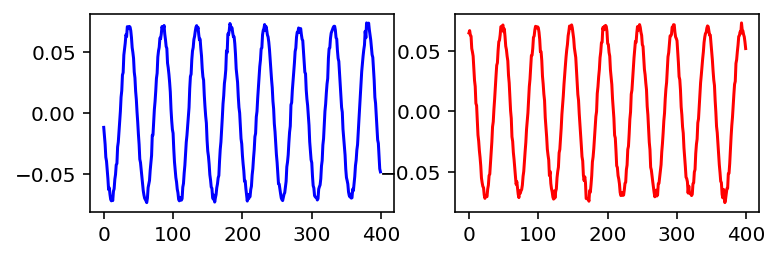

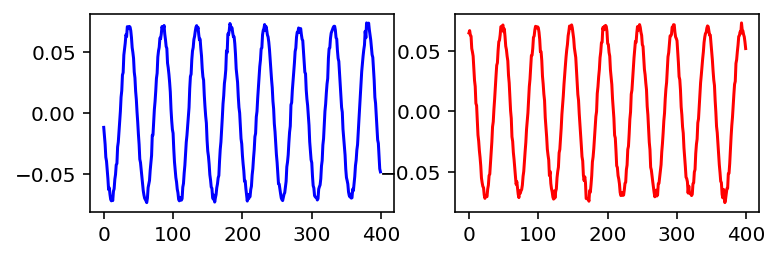

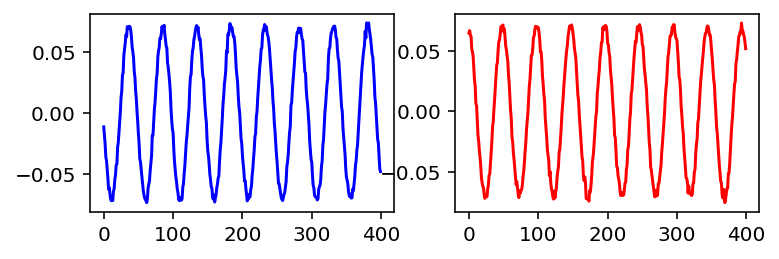

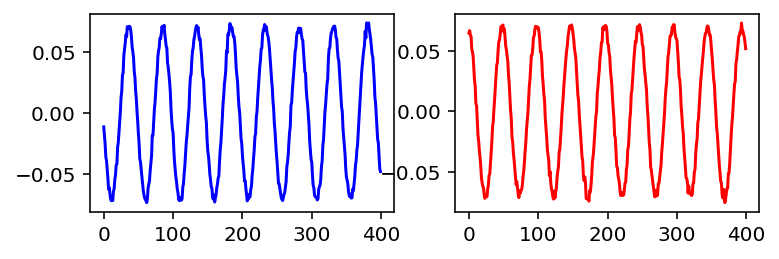

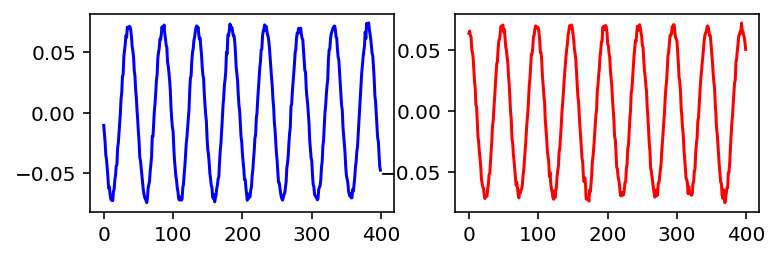

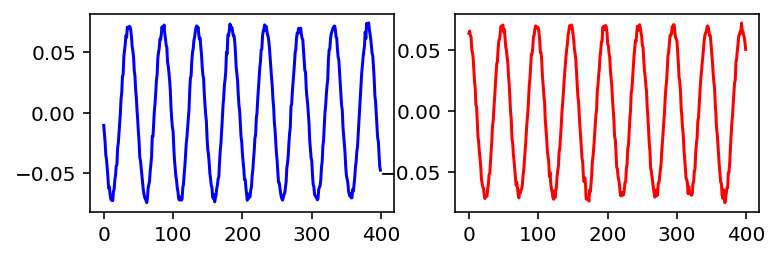

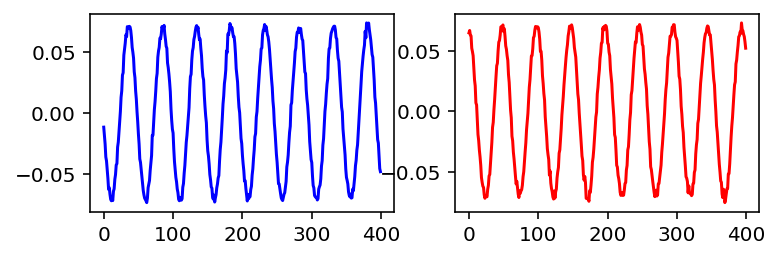

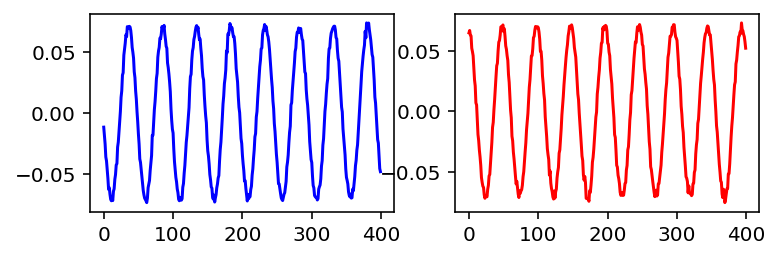

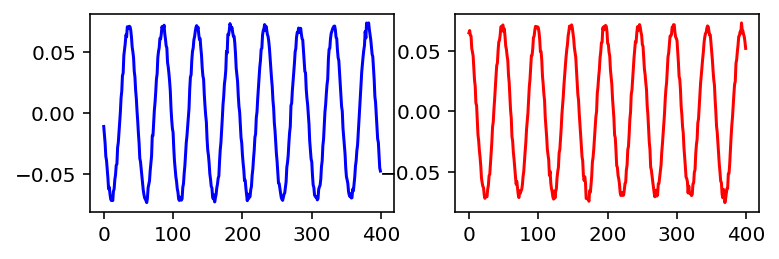

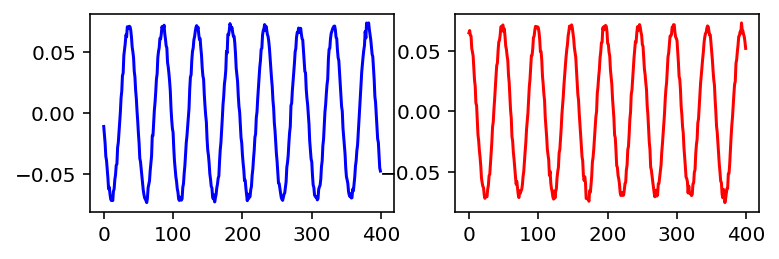

Done with training


In [5]:
n_iterations = 10000
codings = hidden
X_train = xmat.T
X_test = X_train

col = ['b','r','g','c','m','y','k']

sess = tf.InteractiveSession()
init.run()
    
for iteration in range(n_iterations):
    training_op.run(feed_dict={X: X_train})

    if iteration %1000 == 0:
        W_val = W.eval()
        plt.clf()
        for k in range(n_hidden):
            plt.subplot(n_hidden,2,k+1)
            plt.plot(W_val[:,k],col[k % len(col)])
        plt.show(False)
        plt.pause(0.001)

codings_val = codings.eval(feed_dict={X: X_test})

print("Done with training")

##### Question 1 (20 points)

What is an autoencoder? Please explain briefly. What would happen (ideally) if you pass a portion of signal x through the trained network?

``` Your response here ```

An autoencoder is a type of unsupervised neural network used for data reconstruction. 
The trained network filters out noise in signal x.

##### Question 2 (10 points)

Based on the observed shape of n_inputs and the definition of X_train, what exactly is being passed to the input layer of the network for a single forward pass? Be specific!

``` Your response here ```

In [6]:
n_inputs

400

In [7]:
np.shape(X_train)

(148, 400)

`n_inputs` of sequences of `window_size` sampled with an interval of `hop_size` from `x`, the original audio data.

##### Question 3 (10 points)

What variable(s) are used to represent the network weights? How are these weights initialized prior to training?

``` Your response here ```

`W` (or `W_val`) is used represent the weights. The weights are set to be normalized before training.

##### Question  4 (10 points)

What is being minimized in the reconstruction loss? Why is this helpful?

``` Your response here ```

Variance. This is helpful because high variance of the dataset tends to lead to overfitting which prevents the model from generalizing well to new data.

##### Question 5 (10 points)

What is an optimizer? What are 3 common optimizers? Which optimizer is used in this AE training? 

``` Your response here ```

Optimizers are used to tune the hyperparameters (e.g. weights and learning rate) to reduce losses; 
Common optimizers: SGD, RMSprop, Adam; 
Optimizer currently used: Adam.

We can examine now the "codings", i.e. the hidden unit values and their distribution. The more signigicant codings should have smaller variances.

mean:  [0.10081957 0.11706494]
variance [ 9.979041 10.085461]


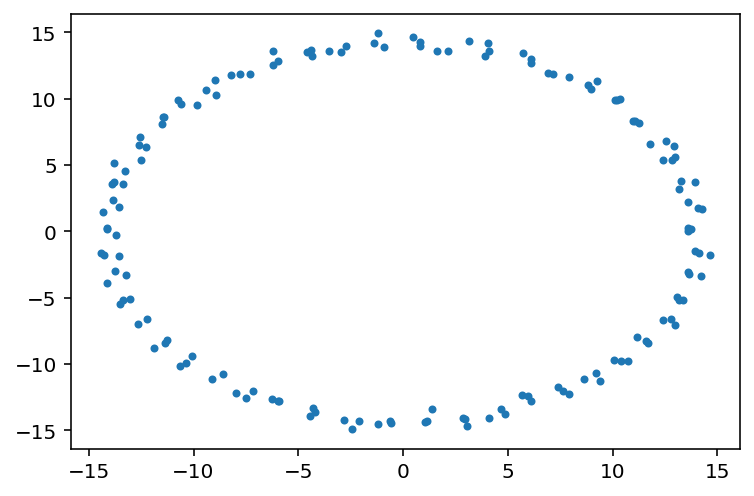

In [8]:
plt.plot(codings_val[:,0],codings_val[:,1],'.')

print ("mean: ", np.mean(codings_val,0))
print ("variance", np.std(codings_val,0))

###### Question 6 (10 points)

In what way does the autoencoder network function similarly to PCA?

``` Your response here ```

A linear autoencoder network function similar to PCA in that they both have encoders and decoders and they pass data through one or multiple hidden layers.

##### PCA versus AE (30 points)

Using sklearn.decomposition.PCA (or another PCA implementation in Python), illustrate the ideas you discuss in Question 1 & Question 7. You should have two plots: one showing the output of the AE network on a single sample, and another showing the output of your PCA on the same sample. How many principal components do you use in your reconstruction to achieve similar performance to the AE network? 


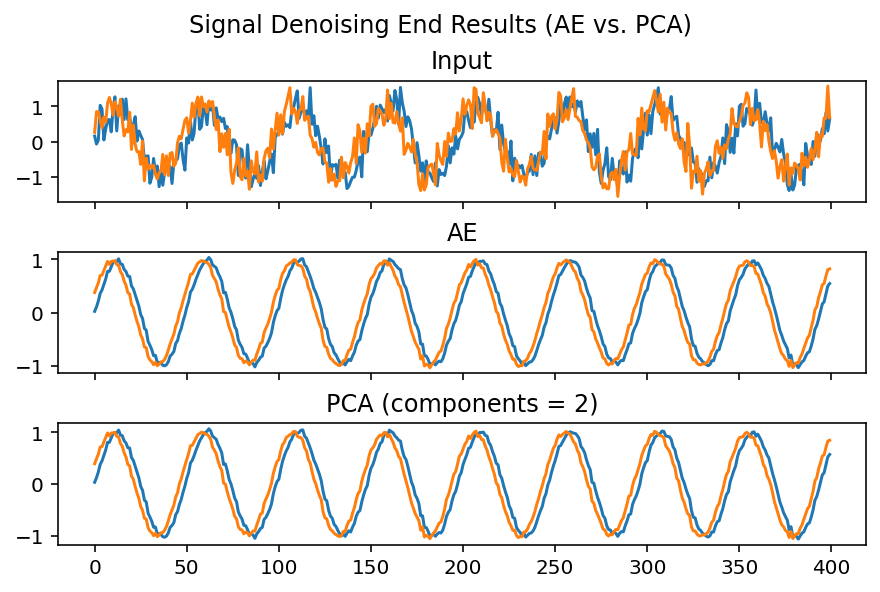

In [9]:
'''
Your code & plots here. 
Please make sure the number of principal components used is clear from your code.
'''

import sklearn as skl
import sklearn.decomposition
import sklearn.preprocessing 


fig, axes = plt.subplots(
    nrows = 3, ncols = 1,
    sharex = True, sharey = False,
    constrained_layout = True
)
fig.suptitle('Signal Denoising End Results (AE vs. PCA)')

sample = np.s_[:,:2]

# Input
input_ = X_train.T
axes[0].set(title = 'Input')
axes[0].plot(input_[sample])

# AE
output_ae = ((input_.T @ W_val) @ W_val.T).T
axes[1].set(title = 'AE')
axes[1].plot(output_ae[sample])

# PCA
n_components = 2
pca = (
    skl.decomposition.PCA(n_components = n_components)
        .fit(
            skl.preprocessing.StandardScaler()
                .fit_transform(input_)
        )
)
output_pca = pca.transform(input_) @ pca.components_
axes[2].set(title = f'PCA (components = {n_components})')
axes[2].plot(output_pca[sample])

fig.show()